# 6章

In [1]:
# minimal imports
import pandas as pd
import numpy as np
from plotnine import *
import plotnine.options as p9options

# needed for 図 6.15
import seaborn as sns

# for graphical enhancement
from mizani.labels import label_date, label_dollar, label_percent, label_comma
from mizani.palettes import brewer_pal
from pysocviz.p9extra import wrap_format
from pysocviz.properties import dcolors

p9options.figure_size = (5.4, 4.8)
theme_set(theme_minimal(base_family='Noto Sans CJK JP'))

In [2]:
# Needed by smoothing and modeling and regression analysis
# You need to install scikit-misc package
from statsmodels.formula.api import ols, glm, logit, phreg
import statsmodels.api as sm
import patsy  # 図 6.11 で必要だが, `cplot` を pysocviz からインポートする場合は不要

# Some utilities functions requreid in the specific situations
from pysocviz.utils import prefix_strip, brackets_replace, cplot, coefplot, tidy_ols

# dataset packages
from gapminder import gapminder
from pysocviz.loader import load_dataset

gss_sm = load_dataset('gss_sm')
gss_lon = load_dataset('gss_lon')
organdata = load_dataset('organdata')

import ssl
ssl._create_default_https_context = ssl._create_unverified_context
lung = sm.datasets.get_rdataset("cancer", "survival").data

## 図 6.1


注: **Plotnine** は現時点では (v0.8) `plotnine.geom.geom_quantile` は RQSS のような加法的な分位点回帰モデルを指定することができません. よって変わりに線形分位点回帰モデルを使用しています.

In [3]:
p = ggplot(gapminder, aes(x='np.log(gdpPercap)', y='lifeExp'))

(
  p + geom_point(alpha=0.1) + geom_smooth(
    color="tomato", fill="tomato", method='rlm'
  ) + geom_smooth(color="steelblue", fill="steelblue", method="lm")
).draw();

(
  p + geom_point(alpha=0.1) + geom_smooth(
    color="tomato", method="lm", size=1.2, formula='y ~ bs(x, 3)',
    se=False
  )
).draw();
(
  p + geom_point(alpha=0.1) + geom_quantile(
    color="tomato", size=1.2, quantiles=[0.20, 0.5, 0.85])
).draw();

/home/ks/.pyenv/versions/3.9.10/lib/python3.9/site-packages/plotnine/stats/smoothers.py:164: PlotnineWarning: Confidence intervals are not yet implemented for RLM smoothing.
/home/ks/.pyenv/versions/3.9.10/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.


## 図 6.2

注: 図 5.26 で言及したのと同様に, 元のサンプルコードは信頼性に欠けます. R なら `ggplot2::scale_color_manual` に名前付きベクトルを, Python なら `plotnine.sacle_color_manual` にディクショナリを与えることをおすすめします.

In [4]:
models = ['Cubic Spline', 'LOESS', 'OLS']
model_colors = brewer_pal('qual', 'Set1')(len(models))
model_colors = dict(zip(models, model_colors))

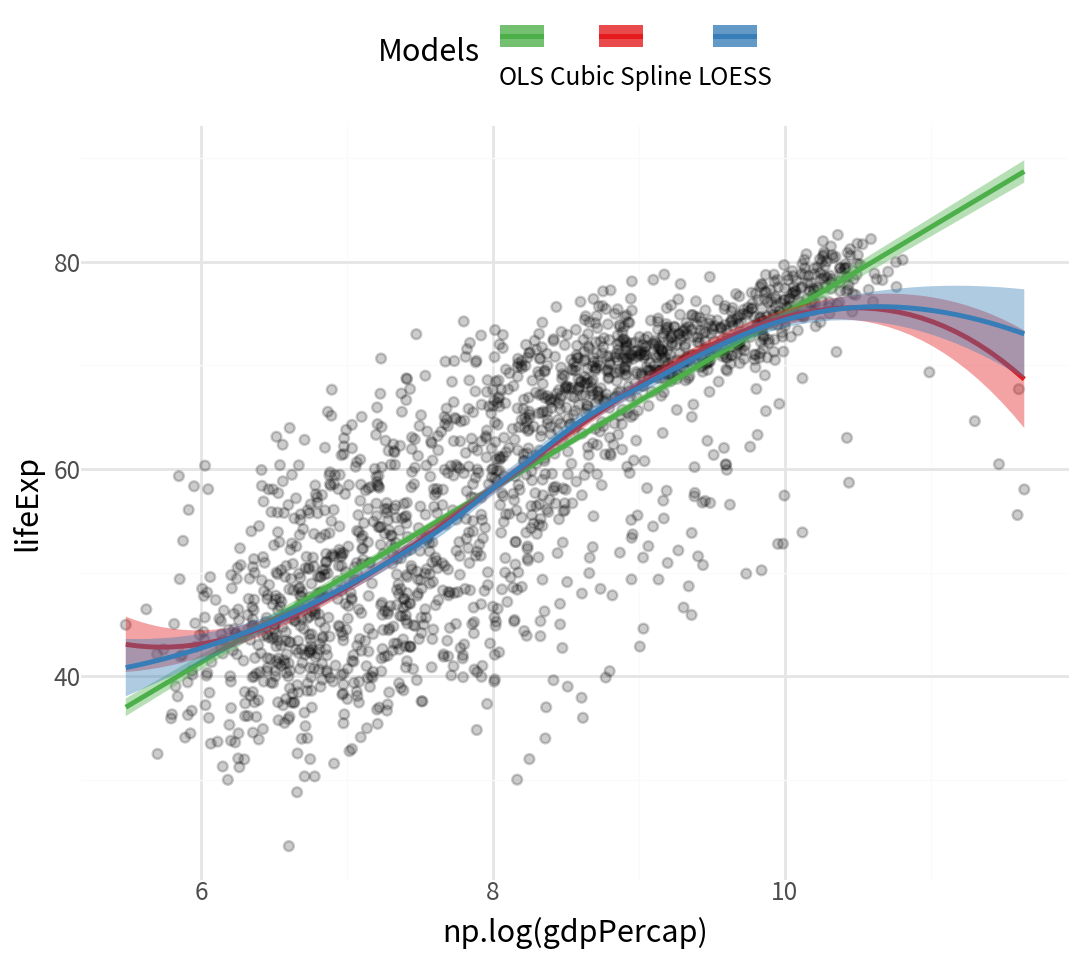

In [5]:
p0 = ggplot(gapminder, aes(x='np.log(gdpPercap)', y='lifeExp'))
p1 = p0 + geom_point(alpha=0.2) + geom_smooth(
  aes(color='"OLS"', fill='"OLS"'),
  method='lm',
) + geom_smooth(
  aes(color='"Cubic Spline"', fill='"Cubic Spline"'),
  method='lm', formula='y ~ bs(x, df = 3)',
) + geom_smooth(aes(color='"LOESS"', fill='"LOESS"'), method='loess')

p1 + scale_color_manual(name="Models", values=model_colors
) + scale_fill_manual(name="Models", values=model_colors
) + theme(legend_position="top")

## 図 6.4

In [6]:
# regression and output tidying

out = ols('lifeExp ~ gdpPercap + pop + continent', data=gapminder).fit()
min_gdp, max_gdp = gapminder['gdpPercap'].min(), gapminder['gdpPercap'].max()
med_pop = gapminder['pop'].median()
pred_df = pd.DataFrame(
  np.array(
    [(gdp, con) for gdp in np.linspace(
      min_gdp, max_gdp, 100
    ) for con in gapminder['continent'].unique()]
  ),
  columns=['gdpPercap', 'continent']
).assign(pop=med_pop, gdpPercap=lambda d: d['gdpPercap'].astype(float))
pred_out = out.get_prediction(pred_df).summary_frame(alpha=.05)  # .predict() cannot display the c.i.
pred_out = pred_out.rename(
  columns={'mean': 'fit', 'obs_ci_lower': 'lwr', 'obs_ci_upper': 'upr'}
)[['fit', 'lwr', 'upr']]
pred_out.head()
pred_df = pd.concat((pred_df, pred_out), axis=1)

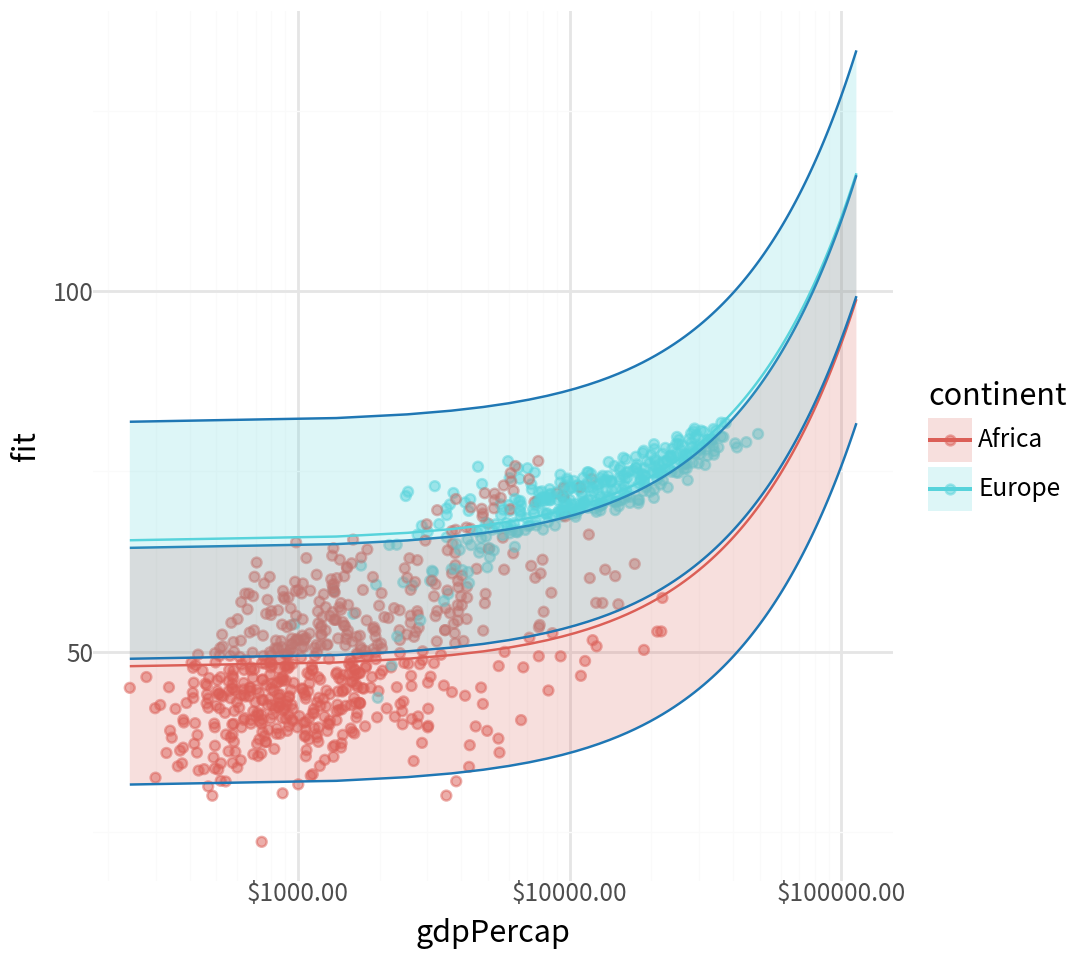

In [7]:
p = ggplot(
  pred_df.loc[lambda d: d['continent'].isin(['Europe', 'Africa'])],
  aes(x='gdpPercap', y='fit', ymin='lwr', ymax='upr', color='continent',
      fill='continent', group='continent')
)

p + geom_point(
  aes(x='gdpPercap', y='lifeExp', color='continent'),
  data=gapminder.loc[lambda d: d['continent'].isin(['Europe', 'Africa'])],
  alpha = 0.5, inherit_aes = False
) + geom_line() + geom_ribbon(
  alpha=0.2, color=None
) + scale_x_log10(labels=label_dollar())

## 図 6.5

注: Python には R における **broom** のようなパッケージはありません. そこで `tidy_ols()` という似たような関数を作成しました. `from pysocviz.utils import tidy_ols` でインポートできます. 実際のコードはこのようになっています:


```python
def tidy_ols(ols_result, conf_int=False):
    tidy = pd.DataFrame(
        {
            'estimate': ols_result.params,
            'std_error': ols_result.bse,
            'statistic': ols_result.tvalues,
            'p_value': ols_result.pvalues
        }
    ).reset_index().rename(columns={'index': 'term'})
    if conf_int:
        tidy = pd.concat([
            tidy,
            ols_result.conf_int().reset_index(drop=True).rename(
                columns={0: 'conf_low', 1: 'conf_high'})
        ], axis=1)
    return tidy
```

In [8]:
out_comp = tidy_ols(out)

out_comp.round(2)

,term,estimate,std_error,statistic,p_value
0,Intercept,47.81,0.34,140.82,0.0
1,continent[T.Americas],13.48,0.60,22.46,0.0
2,continent[T.Asia],8.19,0.57,14.34,0.0
3,continent[T.Europe],17.47,0.62,27.97,0.0
4,continent[T.Oceania],18.08,1.78,10.15,0.0
5,gdpPercap,0.00,0.00,19.16,0.0
6,pop,0.00,0.00,3.33,0.0


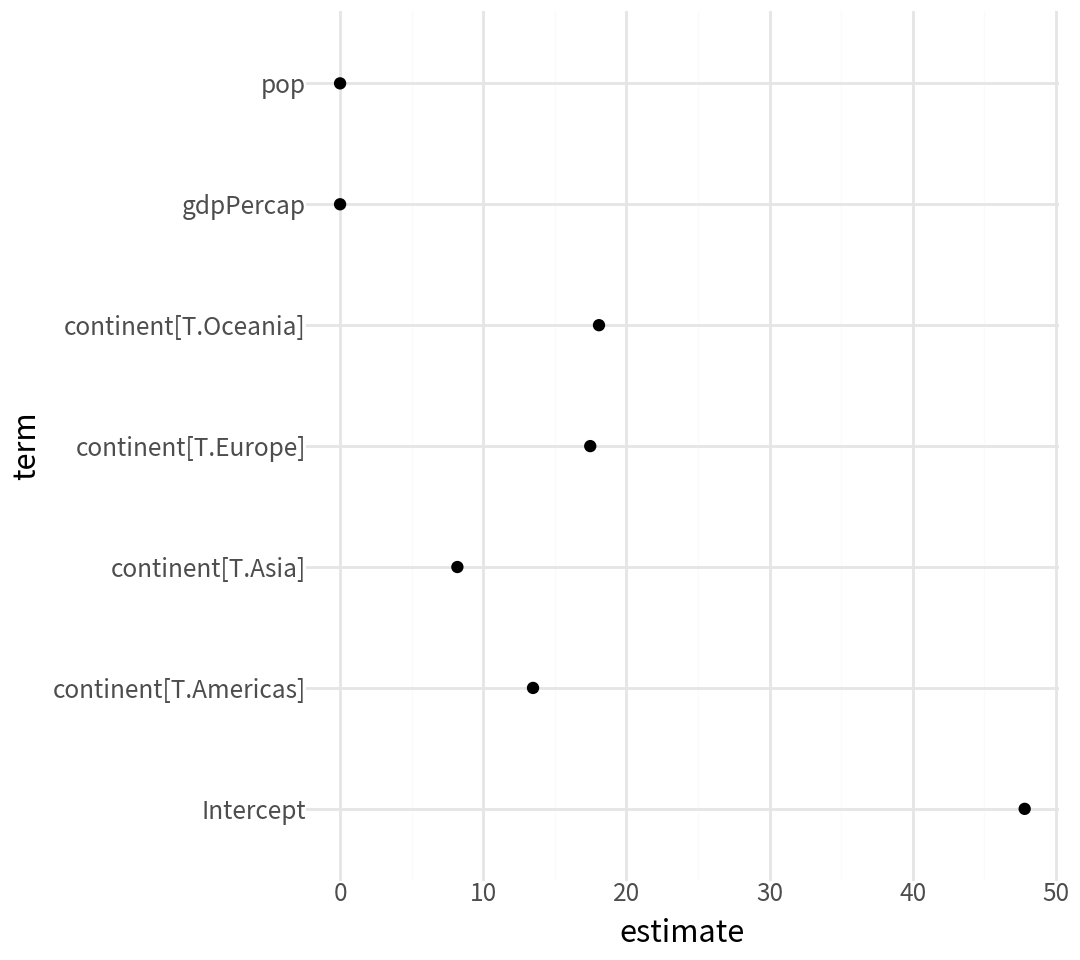

In [9]:
p = ggplot(out_comp, aes(x='term', y='estimate'))
p + geom_point() + coord_flip()

## 図 6.6

注: `term` の表記は R の関数とは異なりますが, Python 側で `prefix_strip()` 関数を定義しました (名前に反してこの関数は prefix のみを除去するわけではありません). この関数は `pandas.Series` に対してのみ機能します. この関数は `from pysocviz.utils import prefix_strip` でインポートできます. 実際のコードはこのようになっています:

```python
def prefix_strip(series):
    return series.str.replace(r"^.+?\[T\.(.+?)\]$", r"\1", regex=True)
```

In [10]:
out_conf = tidy_ols(out, conf_int=True)
out_conf = out_conf.loc[lambda d: ~d['term'].isin(['Intercept'])]
out_conf = out_conf.assign(nicelabs=lambda d: prefix_strip(d['term']))

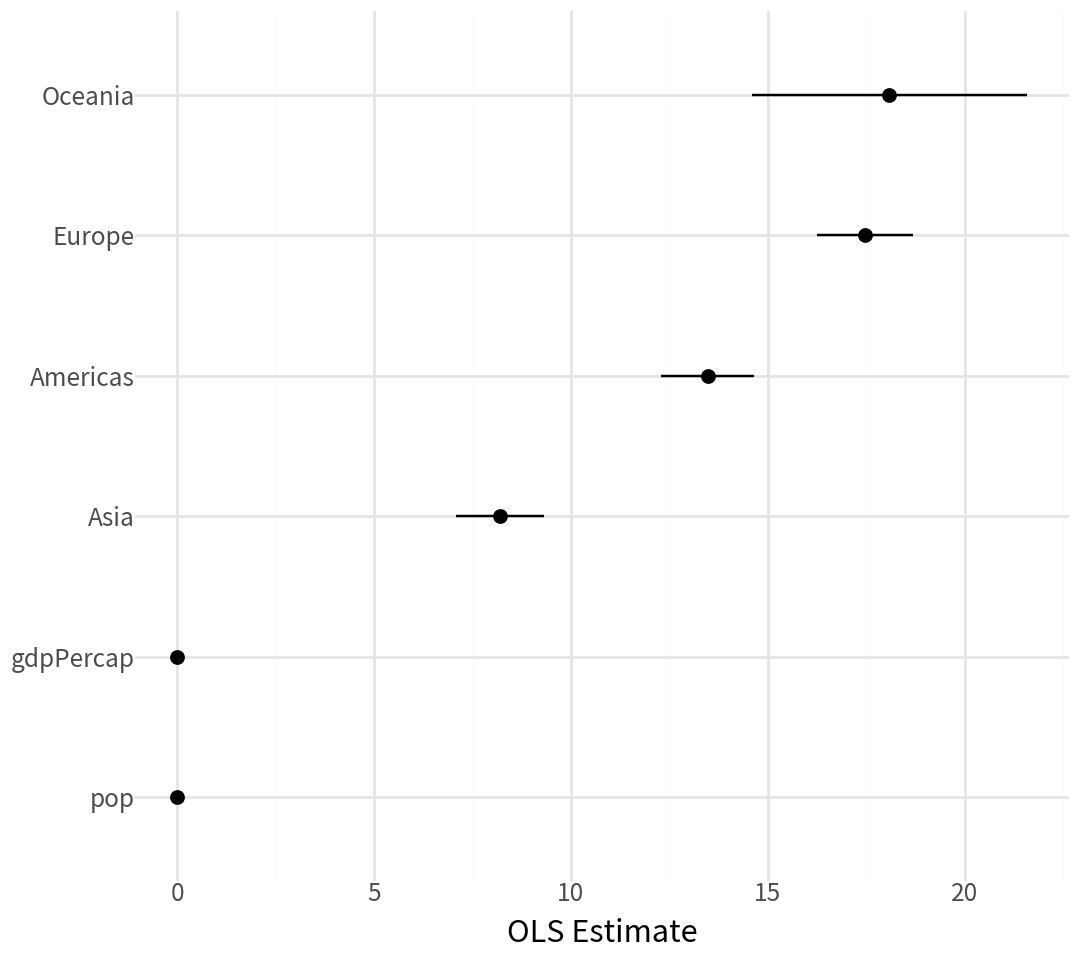

In [11]:
p = ggplot(
      out_conf,
      aes(
          x='reorder(nicelabs, estimate)',
          y='estimate',
          ymin='conf_low',
          ymax='conf_high'
      )
)
p + geom_pointrange() + coord_flip() + labs(x="", y="OLS Estimate")

## 図 6.7

注: `_sigma` の定義は曖昧です. 以下のコードは, DFFITS 統計量のことであろうという私の推測に基づいています.

In [12]:
out_aug = pd.concat([
  gapminder.assign(
    _fitted=out.fittedvalues,
    # _se_fit=None,  # not available for linear regression models
    _resid=out.resid
  ),
  out.get_influence().summary_frame().rename(
    columns={
      'hat_diag': '_hat',
      'cooks_d': '_cooksd',
      'dffits': '_sigma', # TODO: Really?
      'standard_resid': '_std_resid' 
      }
    )[['_hat', '_cooksd', '_sigma', '_std_resid']]
  ],
  axis=1
)

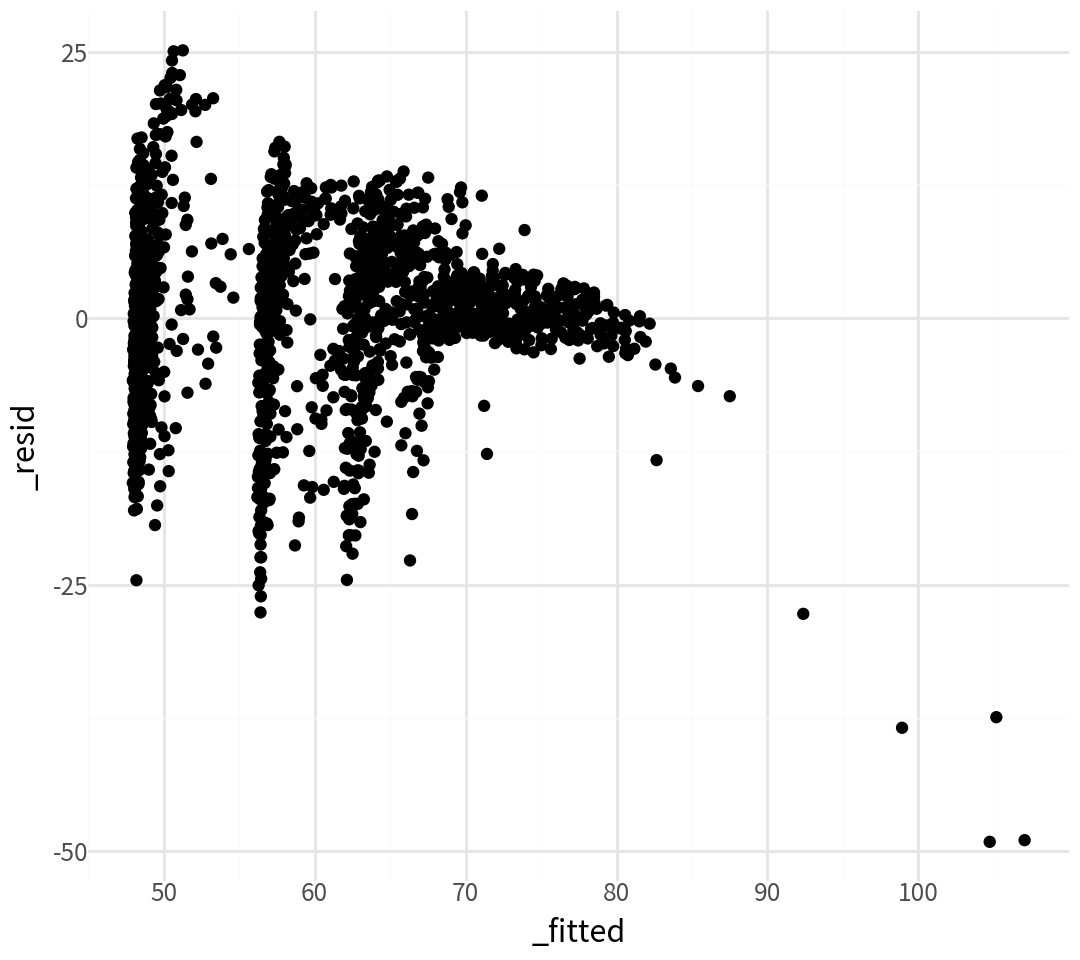

In [13]:
p = ggplot(out_aug, aes(x='_fitted', y='_resid'))
p + geom_point()

## 図 6.8

注 1: 出力データは原著と**同じではありません**. この資料の目的はデータビジュアライゼーションを教えることであるので, **statsmodels** の曖昧なドキュメントから方法をさぐる時間を節約することにしました. よって以下のコードのデータ変換と回帰の部分は**真に受けないで**ください.

注 2: Python で生存時間分析をしたい場合は [lifelines](https://lifelines.readthedocs.io/en/latest/index.html) パッケージを使ったほうがいいかもしれません.

注 3: 元のコードでは `geom_line()` が使用されていますが, 一般にはカプラン・マイヤープロットでは階段関数を使う気がします. さらに言うなら, `geom_line` は既に本書の例で何度も使われています. そこでここでは `geom_step()` 関数の使用例を示すことにします.

In [14]:
out_surv = phreg('time ~ age + sex', data=lung, status=lung['status']).fit()
out_tidy = pd.DataFrame(
    {i: x for i, x in enumerate(out_surv.baseline_cumulative_hazard[0])}
).rename(
    columns={0:'time', 1: 'y1', 2: 'estimate'}
).assign(conf_low=lambda d: d['estimate'] -.3,
         conf_high=lambda d: d['estimate'] + .2
        ) # DON'T do like this!

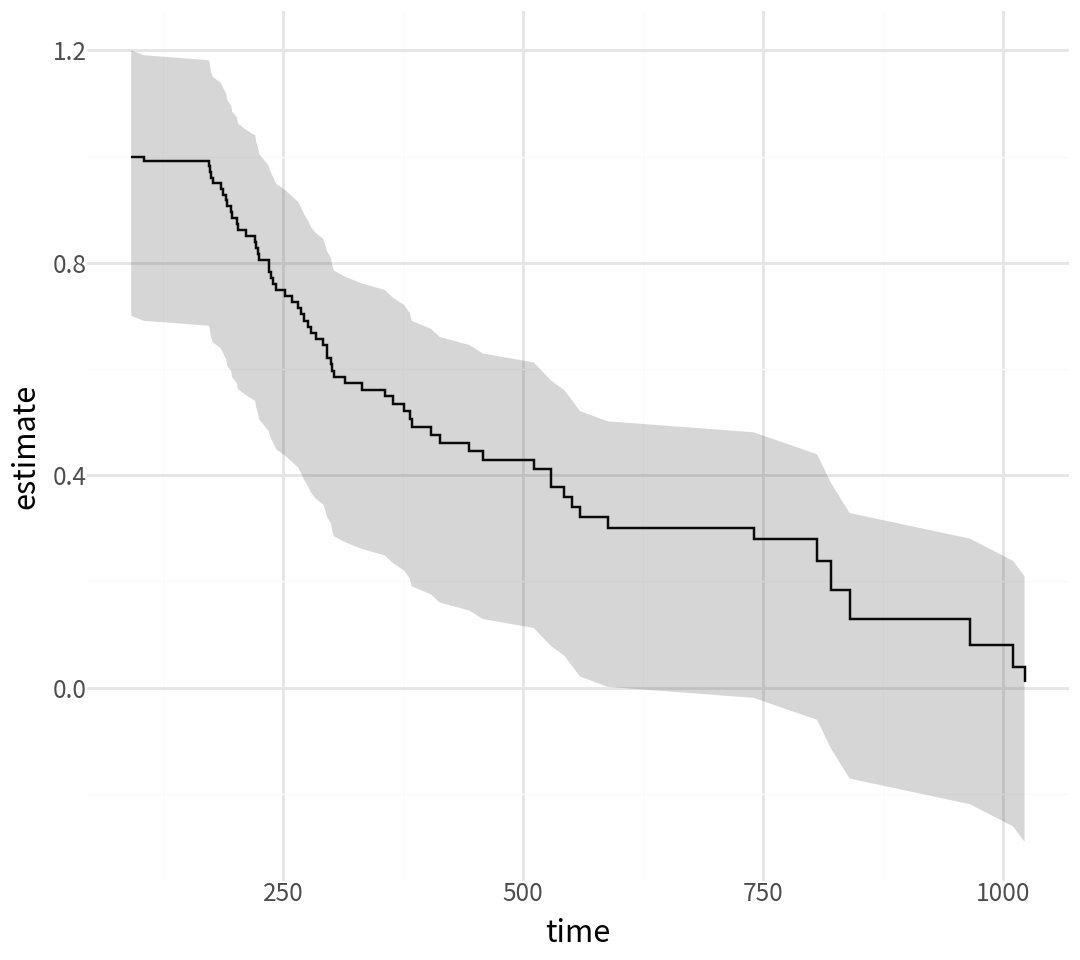

In [15]:
p = ggplot(out_tidy, aes(x='time', y='estimate'))
p + geom_step() + geom_ribbon(aes(ymin='conf_low', ymax='conf_high'), alpha=.2)

## 図 6.9

注1: `pandas.DataFrame` R の `tibble` のようなデータフレームの入れ子を自然に使用できます. ネストされたデータフレームはマルチインデックスで表現されるため, `.reset_index()` で展開できます. 加えて, `pandas.Series` の要素に配列状のものを与えることもできます. その場合は `.explode()` メソッドで展開できます.

注2: ここでは既に定義した `tidy_ols()` を使用しています.

注3: 元のコードでは, 回帰の計算のあとにオセアニアの結果を削除しています. しかしここではリソースの節約と煩雑な警告メッセージを表示させないために, 回帰の前にデータセットからオセアニアのものを除去しています.

In [16]:
out_tidy = gapminder.loc[
    lambda d: ~d['continent'].isin(['Oceania'])
].groupby(['continent', 'year']).apply(
  lambda x: tidy_ols(ols('lifeExp ~ np.log(gdpPercap)', data=x).fit()),
  include_groups=False
).reset_index().drop(columns=['level_2']
).loc[
  lambda d: ~d['term'].isin(['Intercept'])
]

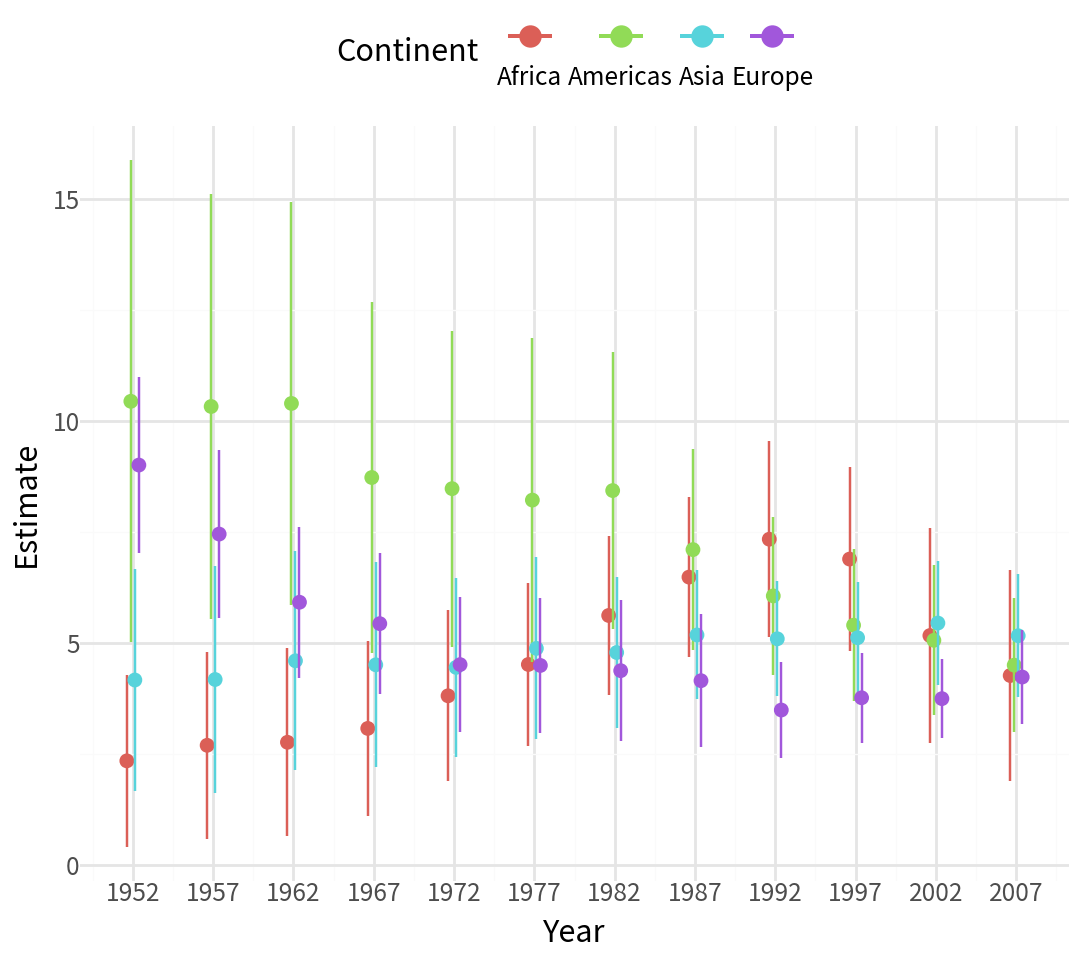

In [17]:
p = ggplot(
  out_tidy,
  aes(
    x='year',
    y='estimate',
    ymin='estimate - 2 * std_error',
    ymax='estimate + 2 * std_error',
    group='continent',
    color='continent'
  )
)
p + geom_pointrange(
  position=position_dodge(width=1)
) + scale_x_continuous(
  breaks=gapminder['year'].unique()
) + theme(legend_position='top') + labs(
  x='Year', y='Estimate', color='Continent'
)

## 図 6.10

注 1: Python には R でいう **magrins** パッケージのようなものはありません. 特に **statsmodels** の `glm` には限界効果を計算するいかなるメソッドも存在しません. しかしこのケースに限れば, モデルはロジスティック回帰モデルと同じであるため, `LogitResults` で代用でき, そしてこのクラスは `get_margeff()` メソッドを持ちます.

注 2: この例では, 原著の `prefix_replace` に対応する `pysocviz.utils.brackets_replace` を導入しています. 実際のコードはこのようになっています.

```python
def brackets_replace(series, sep=': '):
    return series.str.replace(r"^(.+?)\[T\.(.+?)\]$", f"\\1{sep}\\2", regex=True)
```

In [18]:
# glm doesn't have get_megeff method...
model_bo = logit(
    'obama ~ C(polviews, Treatment(reference="Moderate")) + sex * race',
    data=gss_sm
)
out_bo = model_bo.fit()

bo_gg = pd.DataFrame(out_bo.get_margeff(at='mean').summary().tables[1].data)[1:]
bo_gg.columns = ['factor', 'AME', 'std_err', 'z', 'p', 'lower', 'upper']
for c in bo_gg.columns:
    if c != 'factor':
        bo_gg[c] = bo_gg[c].astype(float)
bo_gg = bo_gg.loc[lambda d: d['factor'].str.split(':').apply(len) == 1].assign(
    factor=lambda d: brackets_replace(d['factor'])
).assign(
    factor=lambda d: d['factor'].str.replace('^C\(.+?\)\):', '', regex=True)
)

Optimization terminated successfully.
         Current function value: 0.396313
         Iterations 8


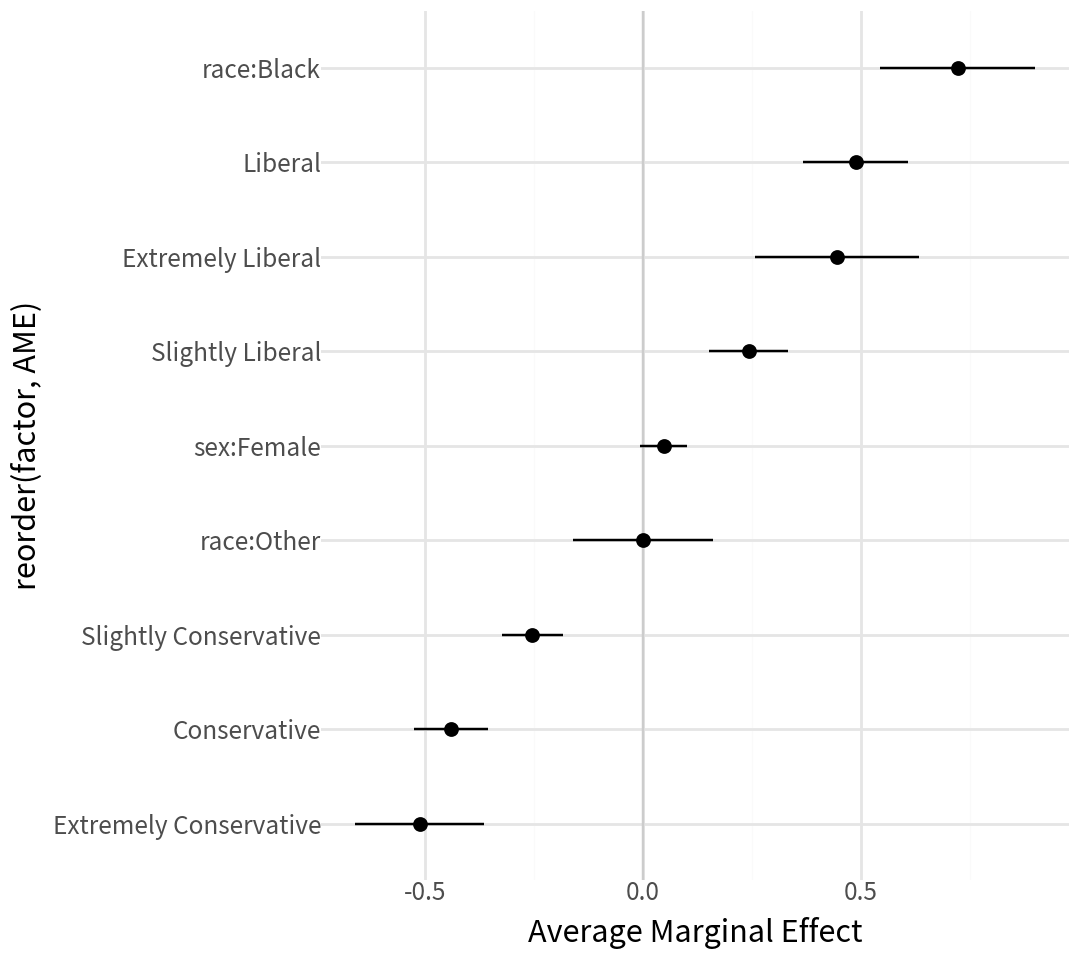

In [19]:
p = ggplot(bo_gg, aes(x='reorder(factor, AME)', y='AME', ymin='lower', ymax='upper'))
p + geom_hline(yintercept=0, color=dcolors["gray80"]) + geom_pointrange(
)  + coord_flip() + labs(x=None, y="Average Marginal Effect") 

## 図 6.11

注: 私は **margins** パッケージに詳しくないため `cplot()` 関数の "conditional predicted values" がどのようにして計算されるのかよくわかりません (ヘルプにも詳細に書かれていません). しかし, いくつかの例で試してみたところ, これはある説明変数を特定の値に固定した上で, 他の数量変数にはデータセット内での**平均値**を, カテゴリ変数は**最瀕値**を代入して計算した予測確率 (response values) であると推理しました. R での `cplot` 関数を簡単化したものを定義しました. ただしこの関数はカテゴリカル変数に対する限界効果の計算のみ想定していますし,  [patsy](https://patsy.readthedocs.io/en/latest/) パッケージの計画行列変換関数の一貫性のなさ (`dmatrix`/`dmatrices` のこと. 実現不可能ではありませんが, とても大変です) から, 処理に非効率性があるという制約があります. この関数は `from pysocviz.utils import cplot` でインポートできます.

In [20]:
def cplot(fit, formula, data, at):
    """
    plotting ommitted, only a data frame.
    """
    funs = {
        name: 'mean' if dtype in [
            'float64', 'int64'
        ] else lambda col: col.value_counts(
        ).index[0] for name, dtype in zip(data.columns, data.dtypes)
    }
    aux = pd.DataFrame(data.agg(funs)).transpose()
    fixed = data[at].unique()
    X = pd.concat([aux.assign(**{at: val}) for val in fixed])
    cpv = fit.predict(X, which='mean')
    # statsmodels は予測信頼区間を計算してくれません.
    # そこでデルタ法に基づいた近似計算をここで行います.
    # 詳細は以下を参考にしてください:
    # https://stackoverflow.com/questions/47414842/confidence-interval-of-probability-prediction-from-logistic-regression-statsmode
    #
    # みにくいトリックをここで使用!
    dmx = patsy.dmatrix(
        formula.split('~')[1],
        pd.concat([data] + [aux.assign(**{at: x}) for x in fixed])
    )[-fixed.shape[0]:, :]
    cov = np.array(fit.cov_params())
    gradient = (np.array(cpv) * (1 - np.array(cpv)) * dmx.T).T
    std_errors = np.array([np.sqrt(np.dot(np.dot(g, cov), g)) for g in gradient])
    c = 1.96
    upper = np.maximum(0, np.minimum(1, cpv + std_errors * c))
    lower = np.maximum(0, np.minimum(1, cpv - std_errors * c))
    return pd.DataFrame({'xvals': fixed, 'yvals': cpv, 'upper': upper, 'lower': lower})

In [21]:
pv_cp = cplot(out_bo, model_bo.formula, gss_sm, at='sex')

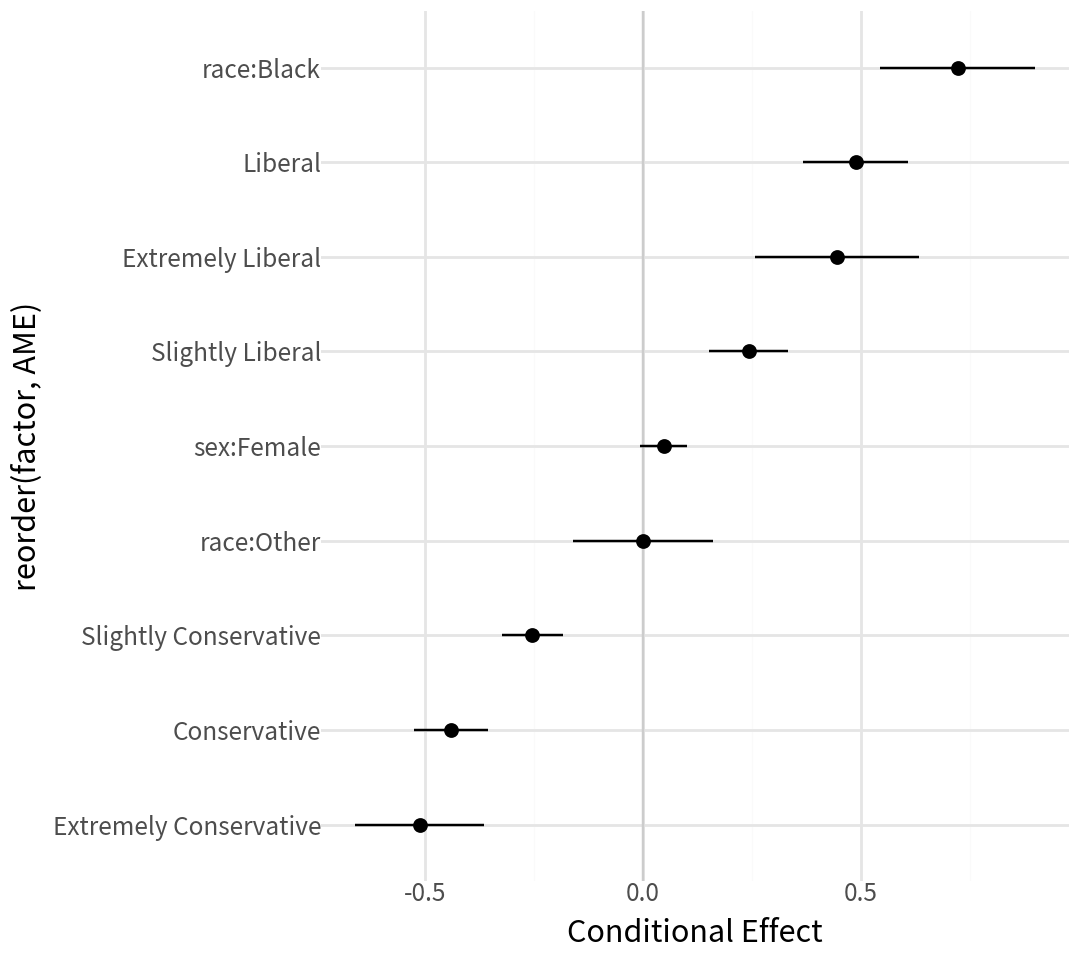

In [22]:
ggplot(
    pv_cp, 
    aes(x='reorder(xvals, yvals)', y='yvals', ymin='lower', ymax='upper')
)

p + geom_hline(
    yintercept=0, color=dcolors['gray80']
) + geom_pointrange() + coord_flip(
) + labs(x=None, y="Conditional Effect") 

## 図 6.12

注 1: Python パッケージではここで使われているパッケージは使用できません. しかしこういったデータセットの再現に疲れてきたので, この例ではデータセットを**正確に再現していません**.

注 2: **mizani** は現時点ではラベルの折返しをサポートしていません. そこで `wrap_format` 関数を私自身で作成しました. `from pysocviz.p9extra import wrap_format` でインポートできます.

In [23]:
out_grp = gss_lon.loc[
    lambda d: d['year'].isin(np.floor(np.linspace(1976, 2016, 4)))
].merge(gss_lon.groupby('year')['age'].sum().reset_index(), on='year').assign(
    prop=lambda d: d['age_x'] / d['age_y'] * 1000
).groupby(['year', 'race', 'degree'])[['prop']].agg({'prop': ['mean', 'sem']}).reset_index()
out_grp = out_grp.assign(year=lambda d: d['year'].astype(int).astype(str))
out_grp.columns = ['year', 'race', 'degree', 'prop', 'prop_se']

/tmp/ipykernel_15515/3974748318.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


/home/ks/.pyenv/versions/3.9.10/lib/python3.9/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_col : Removed 1 rows containing missing values.
/home/ks/.pyenv/versions/3.9.10/lib/python3.9/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_errorbar : Removed 1 rows containing missing values.


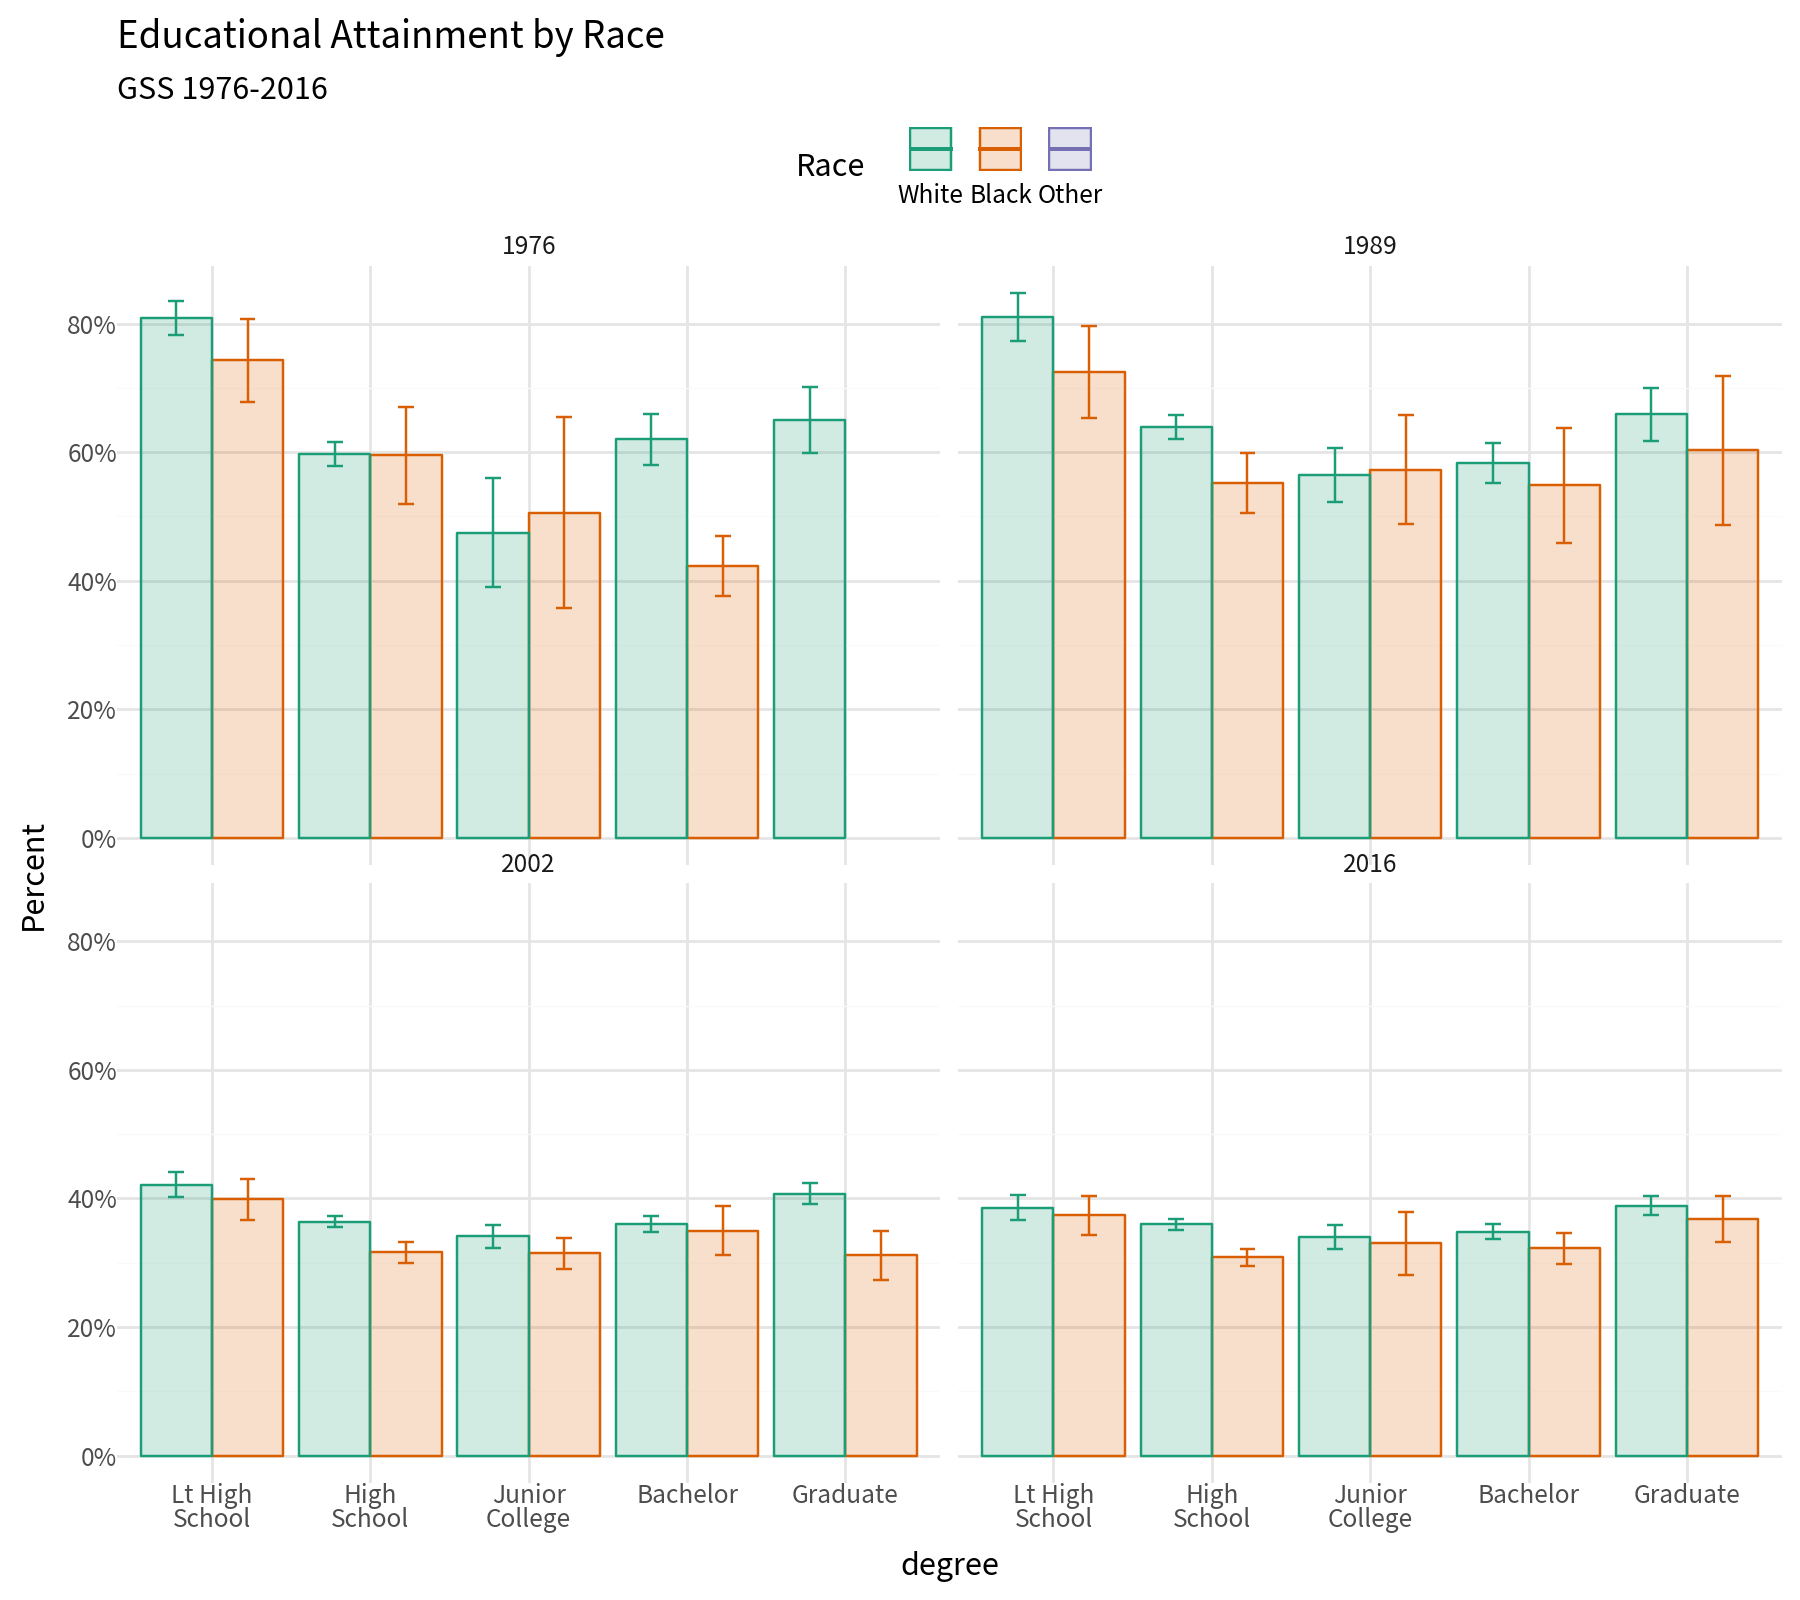

In [24]:
p = ggplot(
    out_grp.loc[lambda d: ~d['race'].isin(['Other'])],
    aes(x='degree', y='prop',
        ymin='prop - 2 * prop_se', ymax='prop + 2 * prop_se',
        fill='race', color='race', group='race'),
)
dodge = position_dodge(width=0.9)
p + geom_col(position=dodge, alpha=0.2
) + geom_errorbar(position=dodge, width=0.2
) + scale_x_discrete(labels=wrap_format(10),
) + scale_y_continuous(labels=label_percent()
) + scale_color_brewer('qual', 'Dark2'
) + scale_fill_brewer('qual', 'Dark2'
) + labs(
    title="Educational Attainment by Race",
    subtitle="GSS 1976-2016",
    fill="Race",
    color="Race",
    x=None,
    y="Percent"
) + facet_wrap('~year', ncol=2
) + theme(legend_position='top', figure_size=(9, 8)) 

## 図 6.13

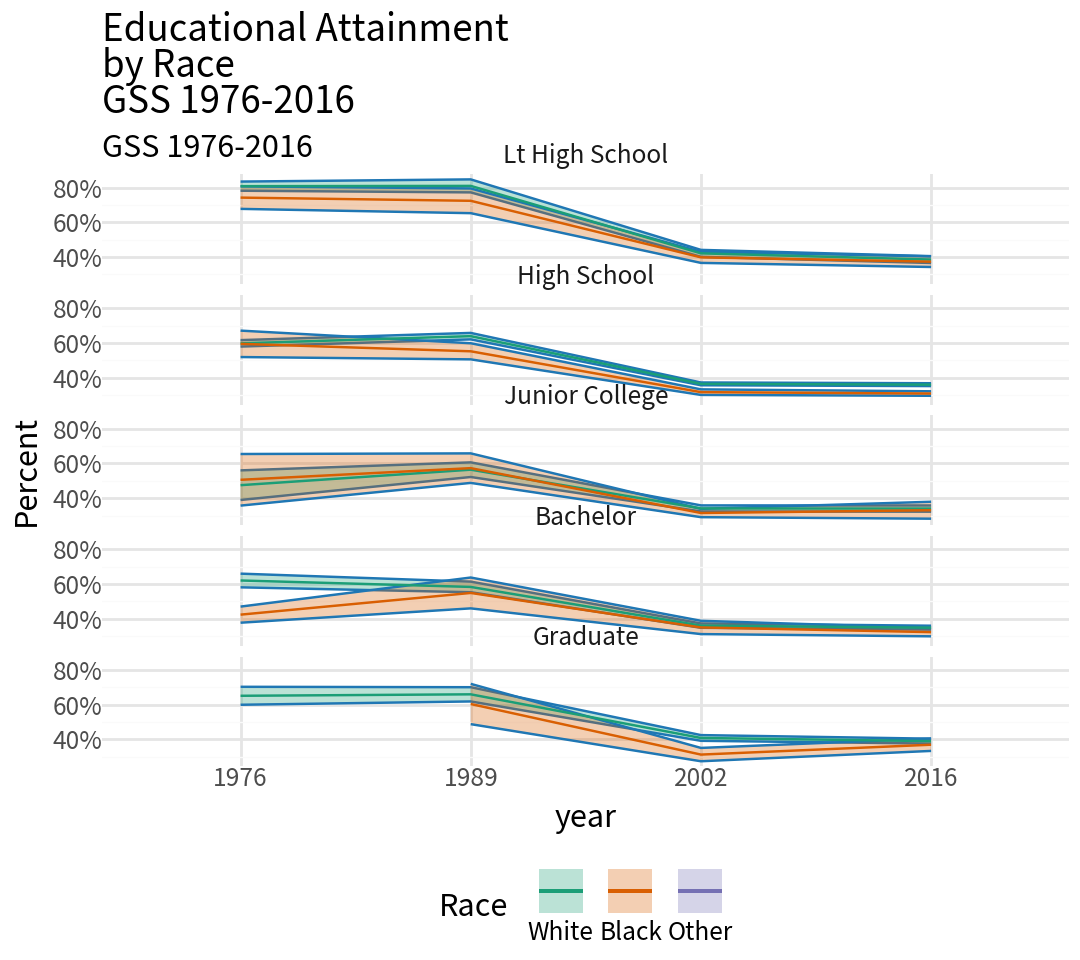

In [25]:
p = ggplot(
    out_grp.loc[lambda d: ~d['race'].isin(['Other'])],
    aes(x='year', y='prop',
        ymin='prop - 2 * prop_se', ymax='prop + 2*prop_se',
        fill='race', color='race', group='race')
)

p + geom_ribbon(alpha=0.3, color=None) + geom_line(
) + facet_wrap('~ degree', ncol=1
) + scale_y_continuous(labels=label_percent()
) + scale_color_brewer('qual', 'Dark2'
) + scale_fill_brewer('qual', 'Dark2'
) + labs(
    title='\n'.join([
        'Educational Attainment\nby Race',
        'GSS 1976-2016'
    ]),
    subtitle="GSS 1976-2016",
    fill="Race",
    color="Race",
    x=None,
    y="Percent"
) + theme(
    legend_position='bottom',
    legend_direction='horizontal'
)

## 図 6.14

注 1: **coefplots** パッケージの代わりに類似の関数を定義していますが, これは `coefplot()` 関数の完全な代替ではありません. オプション引数がかなり限られています. この関数は以前定義した `tidy_ols()` に依存しています. `from pysocviz.utils import coefplot` でインポートできます.

注 2: この関数の出力は図 6.6 とほとんど同じです. よって一般にはこの関数はあまり役に立たないと思います.

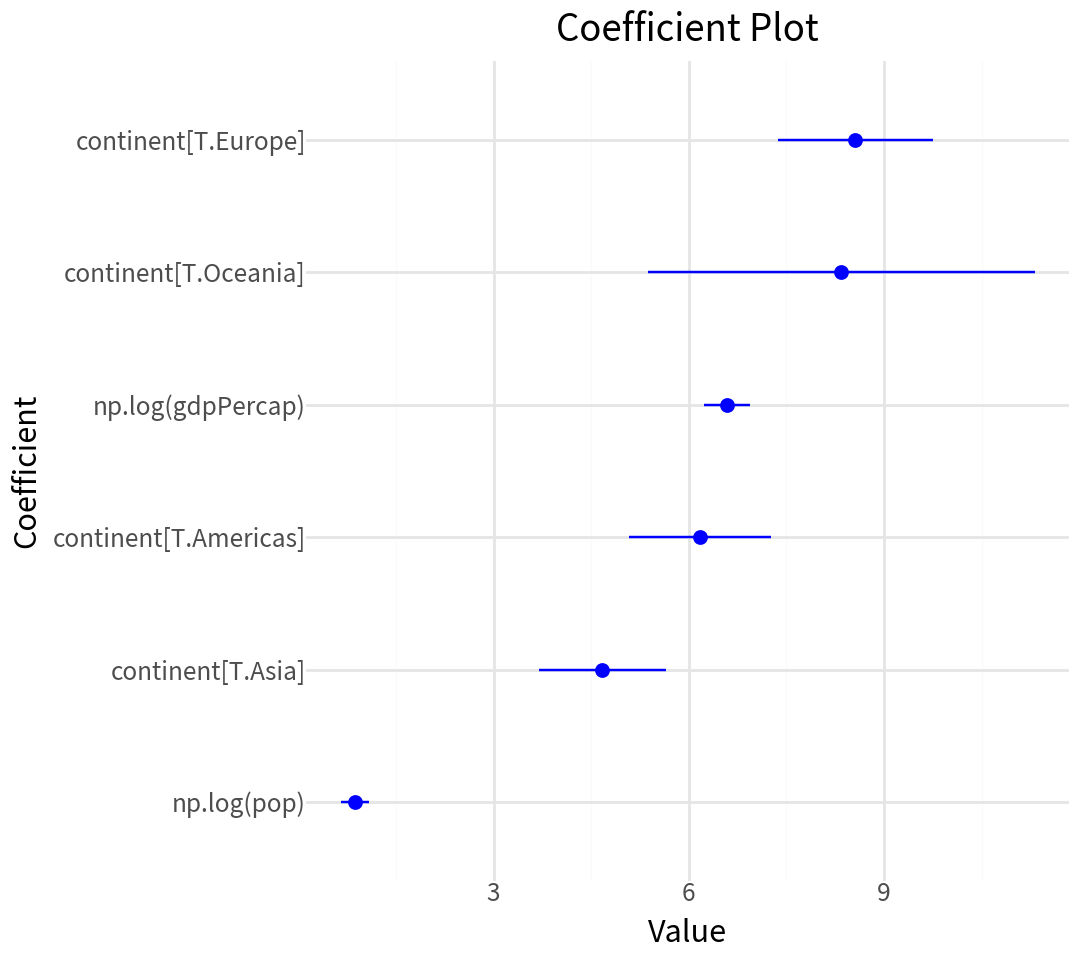

In [26]:
out = ols(
    'lifeExp ~ np.log(gdpPercap) + np.log(pop) + continent',
    data = gapminder
).fit()

coefplot(out, intercept=False, sort='magnitude')

## 図 6.15

注 1: この図の出力はなぜかオンライン版からは欠落しています.

注 2: もちろん **GGallay** パッケージは Python では使えません. しかし **plotnine** で同様のグラフを作るのは難しいです. そこでいくつかの妥協案があります: (1) `pandas.plotting.scatter_matrix` を使う, (2) `seaborn.pairplot` を使う, です. どちらの方法も数量変数とカテゴリカル変数を同時に表示することはできません.

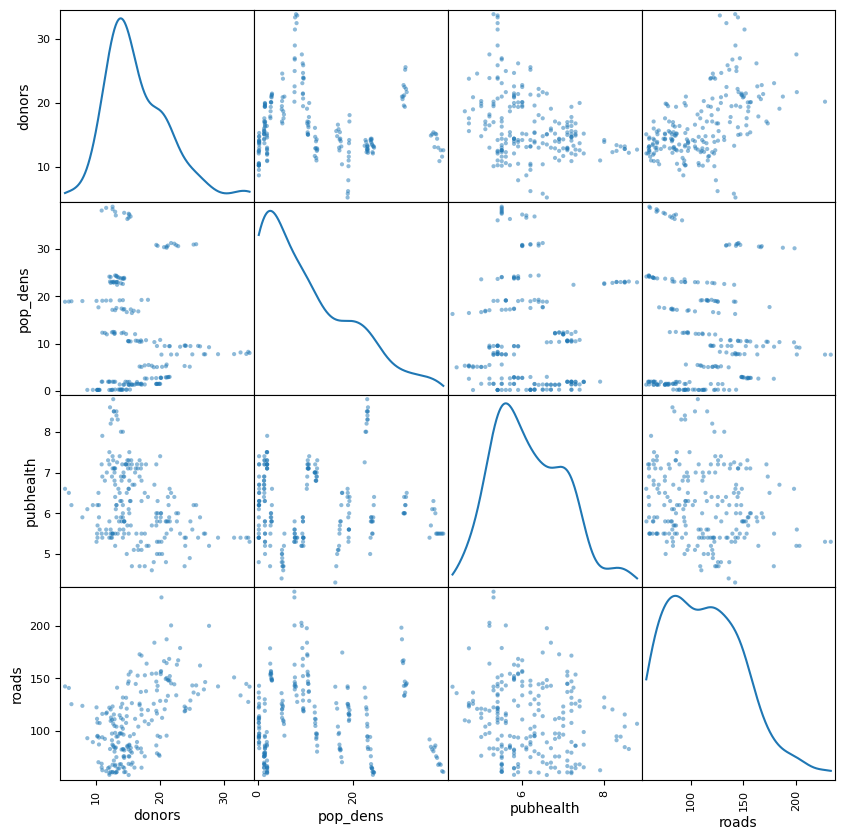

In [27]:
organdata_sm = organdata[['donors', 'pop_dens', 'pubhealth', 'roads', 'consent_law']]

_ = pd.plotting.scatter_matrix(organdata_sm, diagonal='kde', figsize=(10, 10))

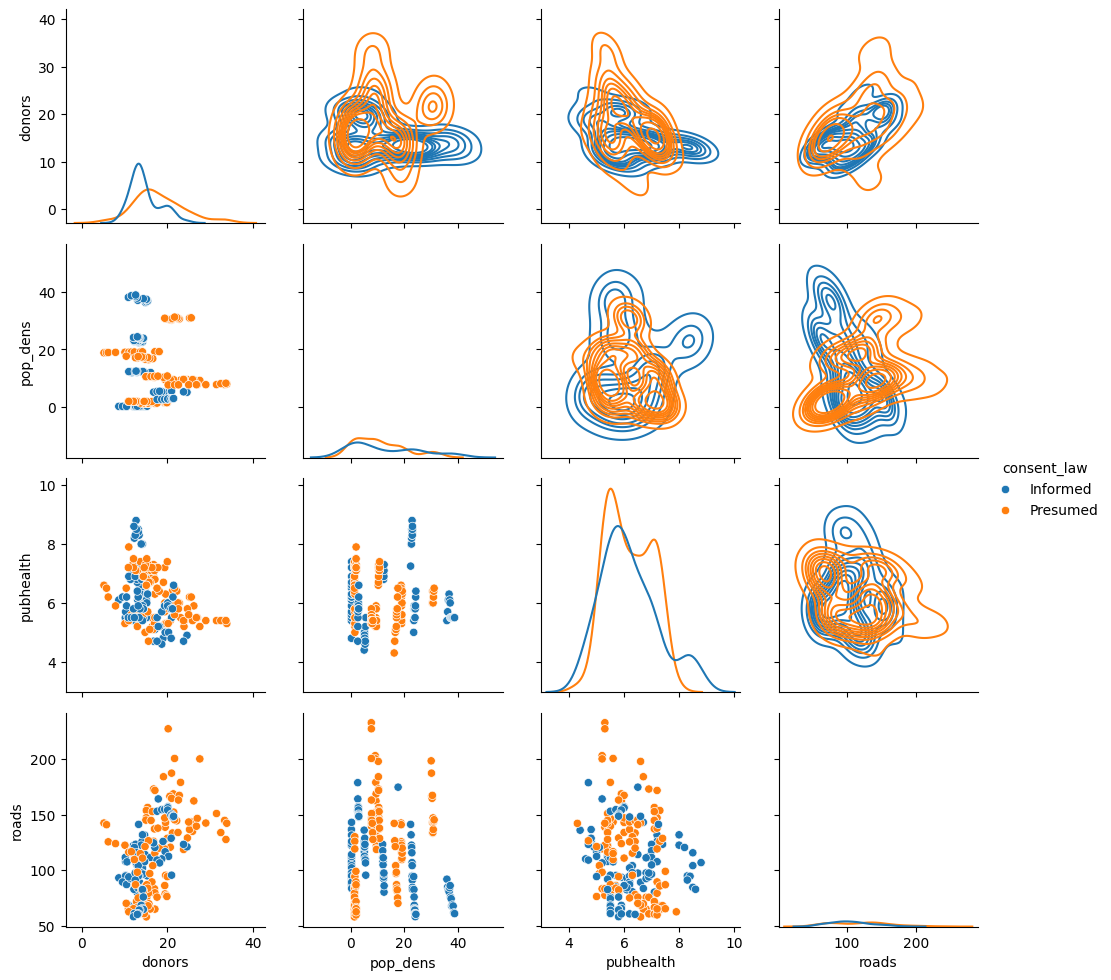

In [28]:
g = sns.PairGrid(organdata_sm, hue='consent_law')
g.map_upper(sns.kdeplot)
g.map_diag(sns.kdeplot)
g.map_lower(sns.scatterplot)
_ = g.add_legend()